# 심층신경망 사용

### 1. 인슐린, 피부두께 냅둠 -> 77%
### 2. 인슐린냅둠, 피부두께 버림 -> 80%
### 3. 인슐린 평균값 대체, 피부두께 버림 -> 76%

In [1]:
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns



In [2]:
train = pd.read_csv('C:/Users/hop09/Downloads/open/train.csv')


In [3]:
train.head()

,ID,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,TRAIN_000,4,103,60,33,192,24.0,0.966,33,0
1,TRAIN_001,10,133,68,0,0,27.0,0.245,36,0
2,TRAIN_002,4,112,78,40,0,39.4,0.236,38,0
3,TRAIN_003,1,119,88,41,170,45.3,0.507,26,0
4,TRAIN_004,1,114,66,36,200,38.1,0.289,21,0


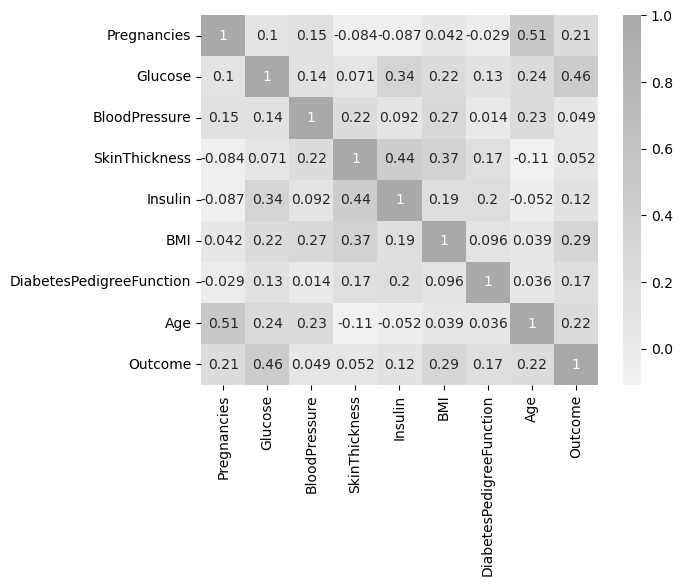

In [4]:
import matplotlib.pyplot as plt

cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(train.corr(), annot=True, cmap=cmap)
plt.show()

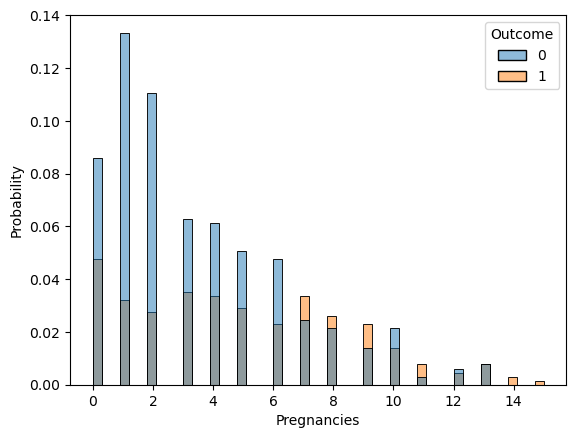

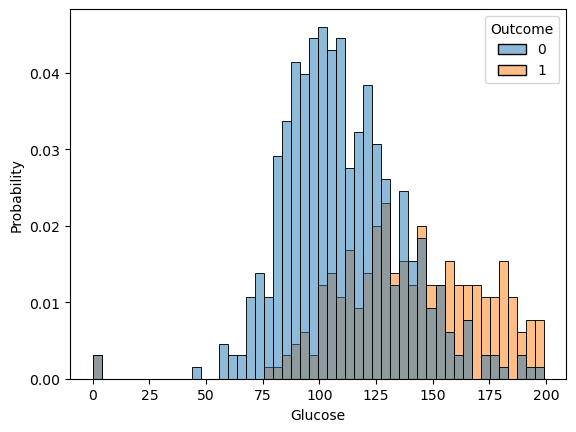

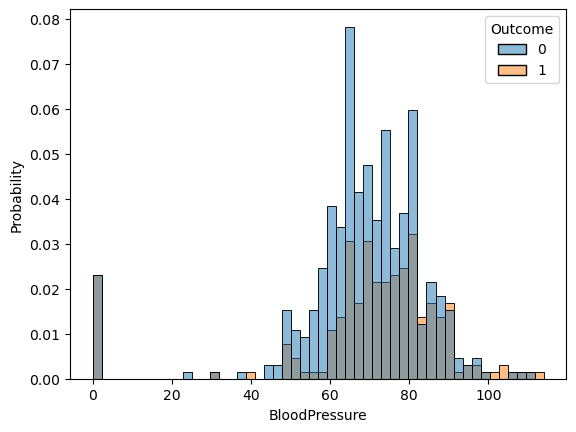

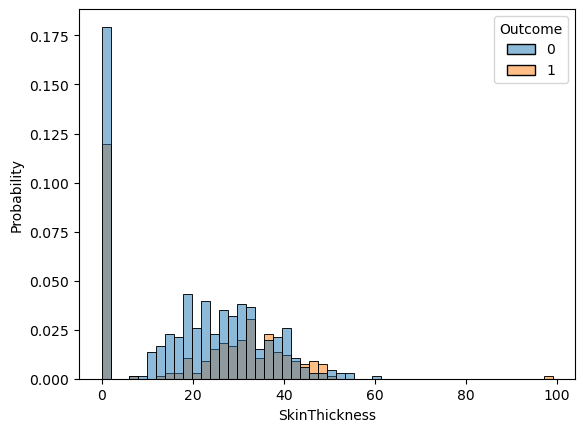

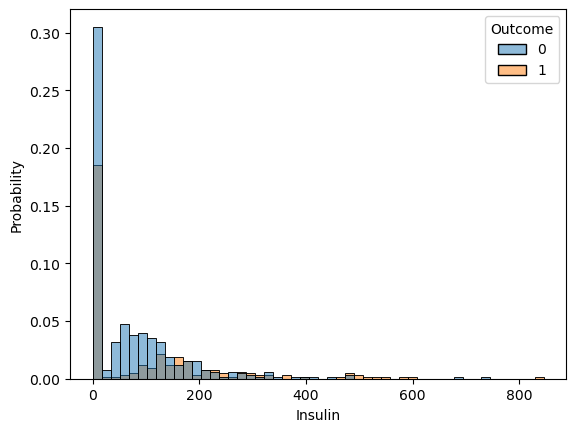

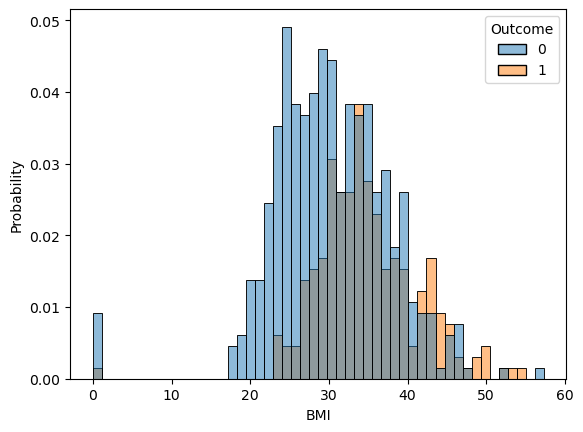

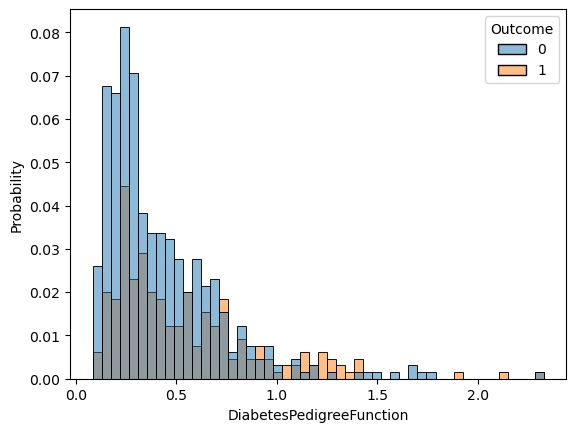

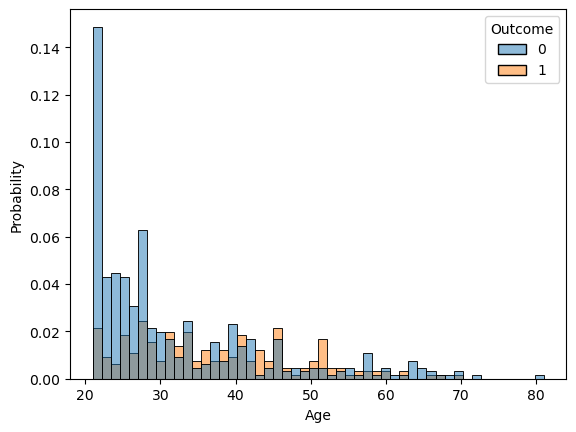

In [6]:
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

for c in cols[:-1] :
	sns.histplot(train, x=c, hue=cols[-1], bins=50, stat='probability')
	plt.show()

# 좃도 소용없네....

### 여기서부터 원하는 컬럼 버리기

In [5]:
# ID, OUTCome
train.drop(axis = 1, columns= ["ID", "SkinThickness", "Pregnancies"], inplace = True)
train.head()

,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,103,60,192,24.0,0.966,33,0
1,133,68,0,27.0,0.245,36,0
2,112,78,0,39.4,0.236,38,0
3,119,88,170,45.3,0.507,26,0
4,114,66,200,38.1,0.289,21,0


In [6]:
#만약 평균값으로 대체하고 싶다면 이거 하기
mean_b = train["BloodPressure"].mean()
train["BloodPressure"].replace(0, mean_b)

mean_bmi = train["BMI"].mean()
train["BMI"].replace(0, mean_bmi)

0      24.0
1      27.0
2      39.4
3      45.3
4      38.1
       ... 
647    29.2
648    31.2
649    38.3
650    30.1
651    26.5
Name: BMI, Length: 652, dtype: float64

In [7]:
train["Insulin"].replace(0,107, inplace = True)

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

data = torch.from_numpy(train.values).float()

x = data[:,:-1]
y= data[:, -1:]

print(x.shape, y.shape)

torch.Size([652, 6]) torch.Size([652, 1])


### 데이터셋, 테스트 셋 나누기

In [22]:
from sklearn.model_selection import KFold

x = np.array(train.values[:,-1:])
y = train.values[:,:-1]

# split 개수, 셔플 여부 및 seed 설정
kfold = KFold(n_splits = 5, shuffle = True)

In [23]:
print(kfold)

KFold(n_splits=5, random_state=None, shuffle=True)


In [9]:
# ratios = [.6,.2,.2]

# train_cnt = int(data.size(0)*ratios[0])
# val_cnt = int(data.size(0)*ratios[1])
# test_cnt = data.size(0) - train_cnt - val_cnt
# cnts = [train_cnt, val_cnt, test_cnt]
# print(cnts)

[391, 130, 131]


In [10]:
# indices = torch.randperm(data.size(0))

# x = torch.index_select(x, dim = 0, index = indices)
# y = torch.index_select(y, dim = 0, index = indices)

# x = x.split(cnts, dim = 0) #
# y = y.split(cnts, dim = 0) #

# for x_i, y_i in zip(x, y) :
# 		print(x_i.size(), y_i.size())

torch.Size([391, 6]) torch.Size([391, 1])
torch.Size([130, 6]) torch.Size([130, 1])
torch.Size([131, 6]) torch.Size([131, 1])


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.iloc[:,:-1]).round(4)

train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns[:-1])
train_scaled_df['target'] = train['Outcome']
train_scaled_df.head()


,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,target
0,-0.5614,-0.4641,0.6484,-1.0660,1.5213,-0.0432,0
1,0.3771,-0.0467,-0.2868,-0.6636,-0.6686,0.2107,0
2,-0.2799,0.4749,-0.2868,0.9996,-0.6959,0.3799,0
3,-0.0609,0.9966,0.4063,1.7910,0.1272,-0.6357,0
4,-0.2173,-0.1511,0.7364,0.8253,-0.5350,-1.0588,0


In [11]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(x[0].numpy())

# x = [torch.from_numpy(scaler.transform(x[0].numpy())).float(),torch.from_numpy(scaler.transform(x[1].numpy())).float(), torch.from_numpy(scaler.transform(x[2].numpy())).float()] 

In [12]:
# print(x[0].size(-1), y[0].size(-1))


6 1


In [30]:
n_epochs = 5000
batch_size = 32
print_interval = 10
early_stop = 100
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(x.size(-1), 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, y.size(-1)),
		nn.Sigmoid(), # 이진분류에서 사용
)

optimizer = optim.Adam(model.parameters())

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from copy import deepcopy

accuracy_history = []
train_history = []
valid_history = []


for train_index, test_index in kfold.split(x): # for문으로 index순회하면서 train, test셋 뽑기
    
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for i in range(n_epochs):
        indices = torch.randperm(X_train.size(0))
        x_ = torch.index_select(X_train, dim=0, index=indices)
        y_ = torch.index_select(y_train, dim=0, index=indices)
    
        x_ = x_.split(batch_size, dim=0)
        y_ = y_.split(batch_size, dim=0)
    
        train_loss, valid_loss = 0, 0
        y_hat = []
    
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()        
            train_loss += float(loss) # This is very important to prevent memory leak.

        train_loss = train_loss / len(x_)
        
        with torch.no_grad():
            x_ = X_test.split(batch_size, dim=0)
            y_ = y_test.split(batch_size, dim=0)
        
            valid_loss = 0
        
            for x_i, y_i in zip(x_, y_):
                y_hat_i = model(x_i)
                loss = F.binary_cross_entropy(y_hat_i, y_i)
            
                valid_loss += float(loss)
            
                y_hat += [y_hat_i]
            
        valid_loss = valid_loss / len(x_)
    
        train_history += [train_loss]
        valid_history += [valid_loss]
        
        if (i + 1) % print_interval == 0:
            print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
        if valid_loss <= lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = i
        
            best_model = deepcopy(model.state_dict())
        else:
            if early_stop > 0 and lowest_epoch + early_stop < i + 1:
                print("There is no improvement during last %d epochs." % early_stop)
                break

    y_hat = torch.cat(y_hat, dim = 0)
    print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
    model.load_state_dict(best_model)




Epoch 10: train loss=5.9347e-01  valid_loss=7.4644e-01  lowest_loss=6.6109e-01
Epoch 20: train loss=5.9739e-01  valid_loss=7.3248e-01  lowest_loss=6.6109e-01
Epoch 30: train loss=5.5673e-01  valid_loss=2.4278e+00  lowest_loss=6.6109e-01
Epoch 40: train loss=5.5551e-01  valid_loss=1.6954e+00  lowest_loss=6.6109e-01
Epoch 50: train loss=5.2416e-01  valid_loss=2.7894e+00  lowest_loss=6.6109e-01
Epoch 60: train loss=5.2784e-01  valid_loss=1.8025e+00  lowest_loss=6.6109e-01
Epoch 70: train loss=4.9797e-01  valid_loss=2.7864e+00  lowest_loss=6.6109e-01
Epoch 80: train loss=5.0502e-01  valid_loss=1.4192e+00  lowest_loss=6.6109e-01
Epoch 90: train loss=4.7344e-01  valid_loss=2.1338e+00  lowest_loss=6.6109e-01
Epoch 100: train loss=4.7240e-01  valid_loss=4.3578e+00  lowest_loss=6.6109e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 7: 6.6109e-01
Epoch 10: train loss=5.9078e-01  valid_loss=6.2264e-01  lowest_loss=6.0439e-01
Epoch 20: train loss=5.6628e-01 

In [15]:
# from copy import deepcopy
# train_history, valid_history = [], []

# for i in range(n_epochs):
#     indices = torch.randperm(x[0].size(0))
#     x_ = torch.index_select(x[0], dim=0, index=indices)
#     y_ = torch.index_select(y[0], dim=0, index=indices)
    
#     x_ = x_.split(batch_size, dim=0)
#     y_ = y_.split(batch_size, dim=0)
    
#     train_loss, valid_loss = 0, 0
#     y_hat = []
    
#     for x_i, y_i in zip(x_, y_):
#         y_hat_i = model(x_i)
#         loss = F.binary_cross_entropy(y_hat_i, y_i)

#         optimizer.zero_grad()
#         loss.backward()

#         optimizer.step()        
#         train_loss += float(loss) # This is very important to prevent memory leak.

#     train_loss = train_loss / len(x_)
        
#     with torch.no_grad():
#         x_ = x[1].split(batch_size, dim=0)
#         y_ = y[1].split(batch_size, dim=0)
        
#         valid_loss = 0
        
#         for x_i, y_i in zip(x_, y_):
#             y_hat_i = model(x_i)
#             loss = F.binary_cross_entropy(y_hat_i, y_i)
            
#             valid_loss += float(loss)
            
#             y_hat += [y_hat_i]
            
#     valid_loss = valid_loss / len(x_)
    
#     train_history += [train_loss]
#     valid_history += [valid_loss]
        
#     if (i + 1) % print_interval == 0:
#         print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
#             i + 1,
#             train_loss,
#             valid_loss,
#             lowest_loss,
#         ))
        
#     if valid_loss <= lowest_loss:
#         lowest_loss = valid_loss
#         lowest_epoch = i
        
#         best_model = deepcopy(model.state_dict())
#     else:
#         if early_stop > 0 and lowest_epoch + early_stop < i + 1:
#             print("There is no improvement during last %d epochs." % early_stop)
#             break

# y_hat = torch.cat(y_hat, dim = 0)
# print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
# model.load_state_dict(best_model)

Epoch 10: train loss=4.1052e-01  valid_loss=4.9229e-01  lowest_loss=4.8063e-01
Epoch 20: train loss=3.2659e-01  valid_loss=5.3544e-01  lowest_loss=4.8063e-01
Epoch 30: train loss=2.4113e-01  valid_loss=8.0123e-01  lowest_loss=4.8063e-01
Epoch 40: train loss=1.7572e-01  valid_loss=1.3767e+00  lowest_loss=4.8063e-01
Epoch 50: train loss=8.9457e-02  valid_loss=2.1037e+00  lowest_loss=4.8063e-01
Epoch 60: train loss=1.4531e-01  valid_loss=1.2118e+00  lowest_loss=4.8063e-01
Epoch 70: train loss=4.7469e-02  valid_loss=2.4410e+00  lowest_loss=4.8063e-01
Epoch 80: train loss=5.9094e-02  valid_loss=2.1871e+00  lowest_loss=4.8063e-01
Epoch 90: train loss=1.4219e-04  valid_loss=1.0214e+01  lowest_loss=4.8063e-01
Epoch 100: train loss=2.2921e-05  valid_loss=1.2033e+01  lowest_loss=4.8063e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 6: 4.8063e-01


<All keys matched successfully>

In [20]:
# test_loss = 0
# y_hat = []

# with torch.no_grad() :
# 		x_ = x[2].split(batch_size, dim = 0)
# 		y_ = y[2].split(batch_size, dim = 0)

# 		for x_i , y_i in zip(x_, y_) :
# 				y_hat_i = model(x_i)
# 				loss = F.binary_cross_entropy(y_hat_i, y_i)
# 				test_loss += loss
# 				y_hat += [y_hat_i]

# test_loss = test_loss / len(x_)
# y_hat = torch.cat(y_hat, dim = 0)

# sorted_history = sorted(zip(train_history, valid_history), key = lambda x : x[1]) #

# print("Train loss : %.4e"%sorted_history[0][0])
# print("Valid loss : %.4e"%sorted_history[0][1])
# print("Test loss : %.4e" % test_loss)

Train loss : 4.3246e-01
Valid loss : 4.8063e-01
Test loss : 5.8877e-01


In [35]:
correct_cnt = (y_test == (y_hat > .5)).sum()
total_cnt = float(y_test.size(0))

print("test Accuracy : %.4f" % (correct_cnt / total_cnt))

test Accuracy : 0.7154


# 테스트 셋 전처리

test = test.drop(columns = ['ID'])
test_scaled = scaler.transform(test)

In [36]:
test = pd.read_csv('C:/Users/hop09/Downloads/open/test.csv')
test.head()

,ID,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,TEST_000,5,112,66,0,0,37.8,0.261,41
1,TEST_001,3,107,62,13,48,22.9,0.678,23
2,TEST_002,3,113,44,13,0,22.4,0.140,22
3,TEST_003,6,190,92,0,0,35.5,0.278,66
4,TEST_004,1,107,72,30,82,30.8,0.821,24


In [37]:
# 예측
test = pd.read_csv('C:/Users/hop09/Downloads/open/test.csv')
test.drop(columns = ["ID", "SkinThickness", "Pregnancies"], inplace = True)


In [38]:
mean_b = test["BloodPressure"].mean()
test["BloodPressure"].replace(0, mean_b)

mean_bmi = test["BMI"].mean()
test["BMI"].replace(0, mean_bmi)

0      37.800000
1      22.900000
2      22.400000
3      35.500000
4      30.800000
         ...    
111    27.500000
112    22.300000
113    36.400000
114    31.600000
115    32.246552
Name: BMI, Length: 116, dtype: float64

In [39]:
type(test)

pandas.core.frame.DataFrame

In [40]:
test_scaler = scaler.transform(test)

test_set = torch.from_numpy(test_scaler).float()


In [41]:
test_set.shape

torch.Size([116, 6])

In [42]:
round(1.735, 0) 

2.0

In [ ]:
test_loss = 0
predict_ = []

with torch.no_grad() :
		x_ = test_set

		for x_i in x_ :
				y_hat_i = model(x_i)
				predict_ += [y_hat_i.round()]


In [30]:
predict = [int(predict.item()) for predict in predict_]

### CSV로 저장

In [31]:
submit = pd.read_csv('C:/Users/hop09/Downloads/open/sample_submission.csv')

In [32]:
submit['Outcome'] = predict

In [33]:
submit.to_csv('C:/Users/hop09/Downloads/open/submit.csv', index = False)